# Simple Linear Regression

This chapter is an intuitive introduction to simple linear regression in a finance context.  In particular, we will fit regressions that demonstrate two stylized facts about volatility in SPY:

1. The Leverage Effect: there is an inverse relationship between implied volatility and returns. 
2. Volatility Clustering: current high/low realized volatility predicts future high/low realized volatility.

Our focus will be on how to implement linear regression in Python, rather than on its mathematical/statistical details.

Linear regression will serve as our first introduction to **sklearn**, a popular package for implementing various machine learning models in Python.

## Import Packages

Let's begin by loading the packages that we will need.

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import pandas as pd
import numpy as np
import sklearn

## Reading-In Data

The dataset that we will analyze in this tutorial consists of weekly volatility metrics for SPY during 2014-2018.  Each row of the `DataFrame` is a set of observations from a specific week.  In particular:


1. `realized_vol` - standard deviation of returns during period (annualized).
2. `ret` - simple return for the period.
3. `start_iv` - the implied vol (variance swap rate) at the start of the period.

Let's read-in the data set and have a look.

In [ ]:
df_spy = pd.read_csv('spy_2014_2018_regression.csv')
df_spy.head()

,underlying,start_date,end_date,realized_vol,ret,start_iv
0,SPY,2014-01-03,2014-01-10,0.052949,0.006812,0.104300
1,SPY,2014-01-10,2014-01-17,0.147207,-0.002719,0.093948
2,SPY,2014-01-17,2014-01-24,0.176336,-0.026206,0.103134
3,SPY,2014-01-24,2014-01-31,0.136391,-0.003977,0.195719
4,SPY,2014-01-31,2014-02-07,0.235160,0.008383,0.182371


## Exploratory Data Analysis: Implied Volatility as a Fear Index

Options are simple insurance contracts that are written on top of an underlying stock.  They protect against large moves in the price of the underlying.  Puts protect against downward moves, calls protect against upward moves.

The *implied volatility* of a stock is a measurement that gauges how much market participants are willing to pay for options on that stock.  Thus, the implied volatility of a stock serves as a index of how fearful market participants are about large moves in the stock price.

**The Leverage Effect:** For many stocks, especially index-ETFs, the following two relationships hold:

1.  Implied volatility increases when the stock experiences losses (negative returns).

2. Implied volatility decreases when the stock experiences gains (positive returns).  

Let's try to see this relationship in our SPY weekly data by means of a simple scatter plot.

First, let's create a new column in `df_spy` - we'll call it `iv_change` - to capture the week over week change of the implied volatility.

In [ ]:
df_spy['iv_change'] = (df_spy['start_iv'] - df_spy['start_iv'].shift(1)).shift(-1)
df_spy.head()

,underlying,start_date,end_date,realized_vol,ret,start_iv,iv_change
0,SPY,2014-01-03,2014-01-10,0.052949,0.006812,0.104300,-0.010352
1,SPY,2014-01-10,2014-01-17,0.147207,-0.002719,0.093948,0.009187
2,SPY,2014-01-17,2014-01-24,0.176336,-0.026206,0.103134,0.092585
3,SPY,2014-01-24,2014-01-31,0.136391,-0.003977,0.195719,-0.013349
4,SPY,2014-01-31,2014-02-07,0.235160,0.008383,0.182371,-0.041966


Next, let's plot the weekly returns (`ret`) against the implied-vol changes (`iv_change`) using the **pandas** built-in plotting functionality.

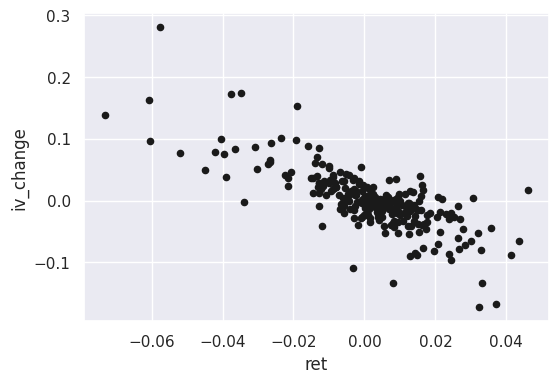

In [ ]:
df_spy.plot.scatter('ret', 'iv_change', c='k', figsize=(6, 4));

Clearly there is a negative relationship, which is what we would expect.

## Regression Example 1:  Returns vs Change in Implied Volatility

In an exploratory data analysis situation, the visualization above may be all we would need to establish the existance of the leverage effect in SPY.  On the other hand, we may want to make this analysis more precise by fitting a *linear regression* line to the data.  A linear regression is a simple model that purports that `iv_change` is a linear function of the `ret`.  Intuitively, when fitting a linear regression we are trying to find the straight line that has the minimium aggregate distance from all the points in our data.

In the language of statistics, the `ret` is the *independent* variable and the `iv_change` is the *dependent* variable.  The field of machine learning uses different terminology: `ret` is called the *feature* and `iv_change` is called the *label*.  In a generic machine learning problem, we seek to predict a *label* from one or more *features*. 

We will use **sklearn** to fit a linear regression to our data.  The first step in any learning task with **sklearn** is to instantiate the model object with a constructor function.  In the case of linear regression, the constructor function is  `LinearRegression()`.  We'll call our model variable `iv_model`.

In [ ]:
from sklearn.linear_model import LinearRegression
iv_model = LinearRegression(fit_intercept=False)

By setting `fit_intercept=False` we are forcing the line to go through the origin.  This seems reasonable from a visual inspection of the data.

Next, we'll separate out the data that will be used to fit the model.

In [ ]:
df_ret = df_spy[['ret']][0:-1] # features
df_iv = df_spy[['iv_change']][0:-1] # labels

We are now ready to fit the model by using the `.fit()` method of `iv_model`.

In [ ]:
iv_model.fit(df_ret, df_iv)

LinearRegression(fit_intercept=False)

Next, let's check the intercept and coefficient of the line that was fit to our data.

In [ ]:
print(iv_model.coef_)
print(iv_model.intercept_)

[[-2.17471827]]
0.0


This means that our linear regression model has determined that the best fitting line is of the form:

\begin{align}
iv\_change = -2.1747 \cdot weekly\_return.
\end{align}

This can be interpreted to mean that every 1% of positive weekly price return leads to a drop in implied volatility of about 2.175%.

We can use the `.predict()` method of our fitted model `iv_model` to predict labels for a given set of features.  In our example, we can predict implied volatility changes for a given set of weekly returns.

Let's try this for -5%, 0%, and 1%.

In [ ]:
test_values = np.array([-0.05, 0, 0.01]).reshape(-1, 1)
iv_model.predict(test_values)

/home/pritam/.local/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


array([[ 0.10873591],
       [ 0.        ],
       [-0.02174718]])

We can also use the `.predict()` method to graph our fitted line along with our data.

/home/pritam/.local/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


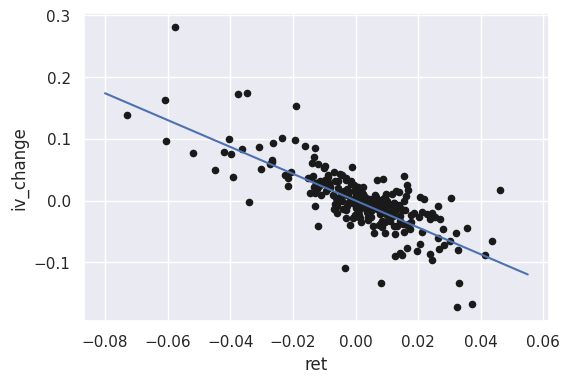

In [ ]:
xfit = np.linspace(-0.08, 0.055, 100)         # range of line
yfit = iv_model.predict(xfit[:, np.newaxis])  # model values in range

df_spy.plot.scatter('ret', 'iv_change', c='k', figsize=(6, 4));
plt.plot(xfit, yfit);

In **sklearn**, all learning models have a `.score()` method which calculates some kind of measure of accuracy or fit.  For a `LinearRegression` model, `.score()` gives the $R^2$.

The $R^{2}$ measures gives a sense for the goodness of fit of a linear regression.  It can be interpreted as the percent of variance in the label that is explained by the features.

In [ ]:
iv_model.score(df_ret, df_iv)

0.5900683519289271

Our linear regression explains 59% of the variance in weekly implied volatility changes, from weekly returns.


There is no universal notion of what is a good or bad $R^2$.  That type of value judgement is context specific.  Based on my experience of looking at financial data, this scatter plot looks pretty good, meaning that the relationship is strong.

## Regression Example 2: Realized Volatility Clustering

A stylized fact about financial asset returns is that realized volatility exhibits clustering.  This means that high volatility tends to be followed by high volatility, and low volatility tends to be followed by low volatility.

Let's try to observe realized voaltility clustering in our weekly SPY data, and then analyze it with linear regression.  In particular, let's observe the relationship between current-week realized volaltility and subsequent-week realized volatility.

We'll begin by first creating new columns in `df_spy` to hold this data.  Notice that `real_vol_0` is just a copy of `realized_vol`.

In [ ]:
df_spy['real_vol_0'] = df_spy['realized_vol']
df_spy['real_vol_1'] = df_spy['realized_vol'].shift(-1)
df_spy.head()

,underlying,start_date,end_date,realized_vol,ret,start_iv,iv_change,real_vol_0,real_vol_1
0,SPY,2014-01-03,2014-01-10,0.052949,0.006812,0.104300,-0.010352,0.052949,0.147207
1,SPY,2014-01-10,2014-01-17,0.147207,-0.002719,0.093948,0.009187,0.147207,0.176336
2,SPY,2014-01-17,2014-01-24,0.176336,-0.026206,0.103134,0.092585,0.176336,0.136391
3,SPY,2014-01-24,2014-01-31,0.136391,-0.003977,0.195719,-0.013349,0.136391,0.235160
4,SPY,2014-01-31,2014-02-07,0.235160,0.008383,0.182371,-0.041966,0.235160,0.063975


Next, let's take a look at a scatter plot of `real_vol_0` vs `real_vol_1`.

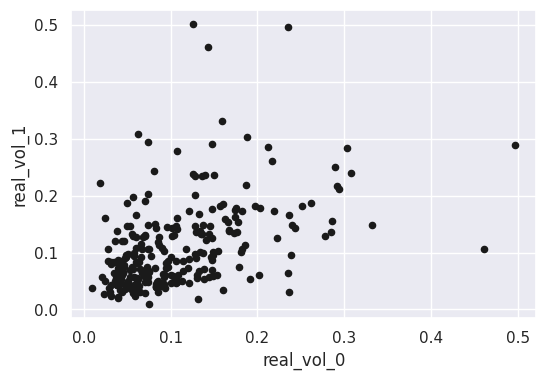

In [ ]:
df_spy.plot.scatter('real_vol_0', 'real_vol_1', c='k', figsize=(6, 4));

At first glance, I would say this scatter plot looks good.  The relationship is clearly positive (although quite noisy), as we would expect from the stylized fact of volatility clustering.

However, the data in data in it's current form is not particularly well suited for linear regression.  First of all, the volatilies are bunched near zero, with a few extremely large observations.  Additionally, standard deviations are by definition always greater than zero.


For both of these reasons, let's take the logs of both variables to make the relationship more clear.  We'll do so by simply repopulating the columns in `df_spy` with the logged values that we want.

In [ ]:
df_spy['real_vol_0'] = np.log(df_spy['realized_vol'])
df_spy['real_vol_1'] = np.log(df_spy['realized_vol']).shift(-1)
df_spy.head()

,underlying,start_date,end_date,realized_vol,ret,start_iv,iv_change,real_vol_0,real_vol_1
0,SPY,2014-01-03,2014-01-10,0.052949,0.006812,0.104300,-0.010352,-2.938431,-1.915913
1,SPY,2014-01-10,2014-01-17,0.147207,-0.002719,0.093948,0.009187,-1.915913,-1.735366
2,SPY,2014-01-17,2014-01-24,0.176336,-0.026206,0.103134,0.092585,-1.735366,-1.992228
3,SPY,2014-01-24,2014-01-31,0.136391,-0.003977,0.195719,-0.013349,-1.992228,-1.447491
4,SPY,2014-01-31,2014-02-07,0.235160,0.008383,0.182371,-0.041966,-1.447491,-2.749269


Let's replot the logged data.

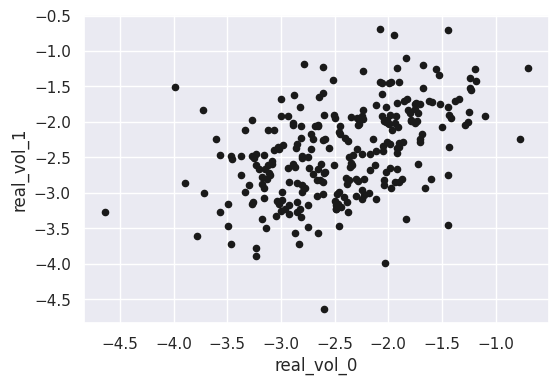

In [ ]:
df_spy.plot.scatter('real_vol_0', 'real_vol_1', c='k', figsize=(6, 4));

The positive relationship looks more linear after taking logs of both the features and the labels.

As in the previous section, let's fit a simple linear regression to this data by executing the following steps:

1. Instantiate a model with the `LinearRegression()` constructor.

1. Isolate the data for fitting.

2. Fit the model with `.fit()`.

3. Check for goodness of fit with `.score()`.

First, let's instantiate our model with the `LinearRegression()` constructor function.  We will call our model `rv_model`.

In [ ]:
rv_model = LinearRegression(fit_intercept=True)

Next, let's isolate the data that we will use to fit the model.

In [ ]:
df_rv_0 = df_spy[['real_vol_0']][:-1]
df_rv_1 = df_spy[['real_vol_1']][:-1]

We can now fit the model to the data using the `.fit()` method of `rv_model`.

In [ ]:
rv_model.fit(df_rv_0, df_rv_1)

LinearRegression()

Lastly, we can check the goodness of fit by first visually inspecting the data, and then also by calculating the $R^2$.

/home/pritam/.local/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


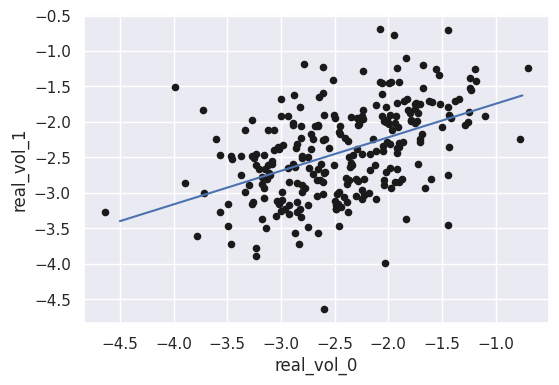

In [ ]:
xfit = np.linspace(-4.5, -0.75, 100)          # range of line
yfit = rv_model.predict(xfit[:, np.newaxis])  # model values in range

df_spy.plot.scatter('real_vol_0', 'real_vol_1', c='k', figsize=(6, 4));
plt.plot(xfit, yfit);

As we can see from the output code below, our $R^2$ is lower for this regression than the previous one (`ret` vs `iv_change`).  This is rather obvious from visual inspection of the two graphs - notice how much more spread out the data points are in this graph, versus the graph in the previous analysis.

In [ ]:
rv_model.score(df_rv_0, df_rv_1)

0.21785126272072308

## Forecasting Realized Volatility

Thus far, our regression analysis involved using the entirety of the five years of SPY data that we have avaialable.  This is typical if you are using regression for exploratory data analysis, or simply to confirm some kind of directional relationship between two variables.

However, machine learning has aspirations beyond mere exploration - the ultimate goal is usually prediction or forecasting.  If you're serious about that objective, it's appropriate to split your data into a *training* set and a *testing* set.  These separate sets are used for two distinct purposes in a two-stage approach:

1. Traing data - used to train/fit/learn the model.  This phase is referred to as the *learning* or *training* phase. 

2. Testing data  - fed into the trained model to produce predictions; we then analyze the predicted values vs true values in the test set to determine the accuracy of the model.  This phase referred to as the *testing* or *generalization* phase.

Let's try using this two-stage approach with our realized volatility data.  

Specifically, rather than fitting a linear regression to the entirety of our data set, let's instead fit it to only the first four years of the data (2014-2017).  We'll then use the fitted/trained model to forecast realized volatility in 2018.

Let's begin by instantiating a new `LinearRegression` object and call it `fcst_model`.

In [ ]:
fcst_model = LinearRegression(fit_intercept=True)

Next, let's grab the training data from 2014-2018.

In [ ]:
df_rv_0_train = df_spy[['real_vol_0']][0:208] # this weeks volatility (feature)
df_rv_1_train = df_spy[['real_vol_1']][0:208] # next weeks volatility (label)

We next fit our model to the training data using `fcst_model.fit()`.

In [ ]:
fcst_model.fit(df_rv_0_train, df_rv_1_train) # fitting the model

LinearRegression()

Let's print the coefficient, the intercept, and the $R^{2}$ from the model.

In [ ]:
print("Coefficent:      ", np.round(fcst_model.coef_[0, 0], 2))    # coefficient
print("Intercept:      ", np.round(fcst_model.intercept_[0], 2))  # intercept
print("R^2 (training):  ", np.round(fcst_model.score(df_rv_0_train, df_rv_1_train), 2)) # R^2 from training

Coefficent:       0.46
Intercept:       -1.34
R^2 (training):   0.21


So our linear model is: 

$$\log(next\_week\_realized\_vol) = 0.46 * \log(this\_week\_realized\_vol) - 1.34.$$

It accounts for about 21% of the variability of the weekly $\log(realized\_vol)$ in the training set.

Let's now apply our trained model to data from 2018.  We begin be separating out the 2018 *testing* data into it's own `DataFrame`.

In [ ]:
df_rv_0_test = df_spy[['real_vol_0']][209:-1] # features
df_rv_1_test = df_spy[['real_vol_1']][209:-1] # labels

We can test how our model predictions compare to the real data by plugging our testing data into the `score()` method of the model.

In [ ]:
fcst_model.score(df_rv_0_test, df_rv_1_test)

0.1484251353811019

Alternatively, we can first calculate the predictions, and then calculate the $R^2$ directly on the predicted values.  In order to do this we would use the `.predict()` method of the LinearRegression object along the `r2_score()` function in the `sklearn.metrics` module.

In [ ]:
sklearn.metrics.r2_score(df_rv_1_test, fcst_model.predict(df_rv_0_test))

0.1484251353811019

Notice that the model is more accurate (i.e. has a higher $R^2$) on the training set than on the testing set - this is almost always the case.

## Updating our Forecasting  Model Daily

In our forcasting exercise above, our `LinearRegression` model was trained on data from 2014-2017, and all of our 2018 forecasts were based on that model.  This is probably not what we would do in practice.  Instead, we would fit a new model on a regular basis.  

In the following code, the training period is updated every week to the most recent four years.  We would hope to see slightly improved performance over just training the model once.  (The code below is also indcative of patterns used when conducting a backtest.)

In [ ]:
ix_start = 0
ix_end = 208

forecasts = np.zeros(50)
fcst_model_2 = LinearRegression(fit_intercept=True)
for ix_end in range(208, 258, 1):
    # setting training period start date   
    ix_start = ix_end - 208
    
    # selecting training data
    df_rv_0_train = df_spy[['real_vol_0']][ix_start:ix_end]
    df_rv_1_train = df_spy[['real_vol_1']][ix_start:ix_end]
    
    # fitting the model
    fcst_model_2.fit(df_rv_0_train, df_rv_1_train)
    
    # forecasting with the newly fitted model
    real_vol = df_spy['real_vol_0'].values[ix_end]
    fcst_rv = fcst_model_2.coef_[0, 0] * real_vol  + fcst_model_2.intercept_[0]
    
    # saving the current forecast
    forecasts[ix_start] = fcst_rv

As we can see, there is a slight improvement when updating the model daily - an $R^2$ of 0.1817 vs 0.1484.  I would not expect the improvement to be that significant given the simplistic nature of our forecasting mechanism.

In [ ]:
sklearn.metrics.r2_score(df_spy[['real_vol_1']][208:258], forecasts)

0.18178835397754134

## Further Reading

*Python Data Science Handbook (VanderPlas)* - 5.1 - What Is Machine Learning?

*Python Data Science Handbook (VanderPlas)* - 5.2 - Introducing Scikit-Learn

*Python Data Science Handbook (VanderPlas)* - 5.3 - Hyperparameters and Model Validation

*Python Data Science Handbook (VanderPlas)* - 5.4 - Feature Engineering

*Python Data Science Handbook (VanderPlas)* - 5.6 - In Depth: Linear Regression